In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [5]:
augmented_icm_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/GT_ICM'
augmented_zp_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/GT_ZP'
augmented_te_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/GT_TE'
augmented_images_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/Images'

# read the images and masks
images = []
zp_masks = []
te_masks = []
icm_masks = []
SIZE = 128

file_names = os.listdir(augmented_images_dir)

for file_name in file_names:
    image_path = os.path.join(augmented_images_dir, file_name)
    zp_mask_path = os.path.join(augmented_zp_dir, file_name.replace('.png', ' ZP_Mask.png'))
    te_mask_path = os.path.join(augmented_te_dir, file_name.replace('.png', ' TE_Mask.png'))
    icm_mask_path = os.path.join(augmented_icm_dir, file_name.replace('.png', ' ICM_Mask.png'))

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    zp_mask = cv2.imread(zp_mask_path, cv2.IMREAD_GRAYSCALE)
    te_mask = cv2.imread(te_mask_path, cv2.IMREAD_GRAYSCALE)
    icm_mask = cv2.imread(icm_mask_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, (SIZE, SIZE))
    zp_mask = cv2.resize(zp_mask, (SIZE, SIZE))
    te_mask = cv2.resize(te_mask, (SIZE, SIZE))
    icm_mask = cv2.resize(icm_mask, (SIZE, SIZE))

    # Add channel dimension and normalize
    image = np.expand_dims(image, axis=-1) / 255.0
    zp_mask = np.expand_dims(zp_mask, axis=-1) / 255.0
    te_mask = np.expand_dims(te_mask, axis=-1) / 255.0
    icm_mask = np.expand_dims(icm_mask, axis=-1) / 255.0

    images.append(image)
    zp_masks.append(zp_mask)
    te_masks.append(te_mask)
    icm_masks.append(icm_mask)

# Convert lists to numpy arrays
images = np.array(images)
zp_masks = np.array(zp_masks)
te_masks = np.array(te_masks)
icm_masks = np.array(icm_masks)

In [6]:
print(images.shape)
print(zp_masks.shape)
print(te_masks.shape)
print(icm_masks.shape)

(747, 128, 128, 1)
(747, 128, 128, 1)
(747, 128, 128, 1)
(747, 128, 128, 1)


In [7]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, zp_masks, test_size=0.2, random_state=42)

In [8]:
def conv_block(input, num_filters):
    conv = keras.layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = keras.layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = keras.layers.MaxPooling2D((2, 2))(conv)
    return conv, pool
def decoder_block(input, skip_features, num_filters):
    uconv = keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = keras.layers.concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

def build_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = keras.models.Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(SIZE, SIZE, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=['accuracy'])

In [10]:
EPOCHS = 50

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_val,y_val),callbacks=[early_stopping],
                    batch_size=64)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 888ms/step - accuracy: 0.8527 - loss: 0.2637 - val_accuracy: 0.8564 - val_loss: 0.2578
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 811ms/step - accuracy: 0.8603 - loss: 0.2436 - val_accuracy: 0.8619 - val_loss: 0.2483
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 873ms/step - accuracy: 0.8592 - loss: 0.2582 - val_accuracy: 0.8618 - val_loss: 0.2467
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 857ms/step - accuracy: 0.8739 - loss: 0.2304 - val_accuracy: 0.8715 - val_loss: 0.2241
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 791ms/step - accuracy: 0.8669 - loss: 0.2301 - val_accuracy: 0.8953 - val_loss: 0.1966
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 767ms/step - accuracy: 0.9005 - loss: 0.1857 - val_accuracy: 0.8725 - val_loss: 0.2267
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 790ms/step - accuracy: 0.8940 - loss: 0.1909 - val_accuracy: 0.9048 - val_loss: 0.1686
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 784ms/step - accuracy: 0.9108 - loss: 0.1572 - val_accura

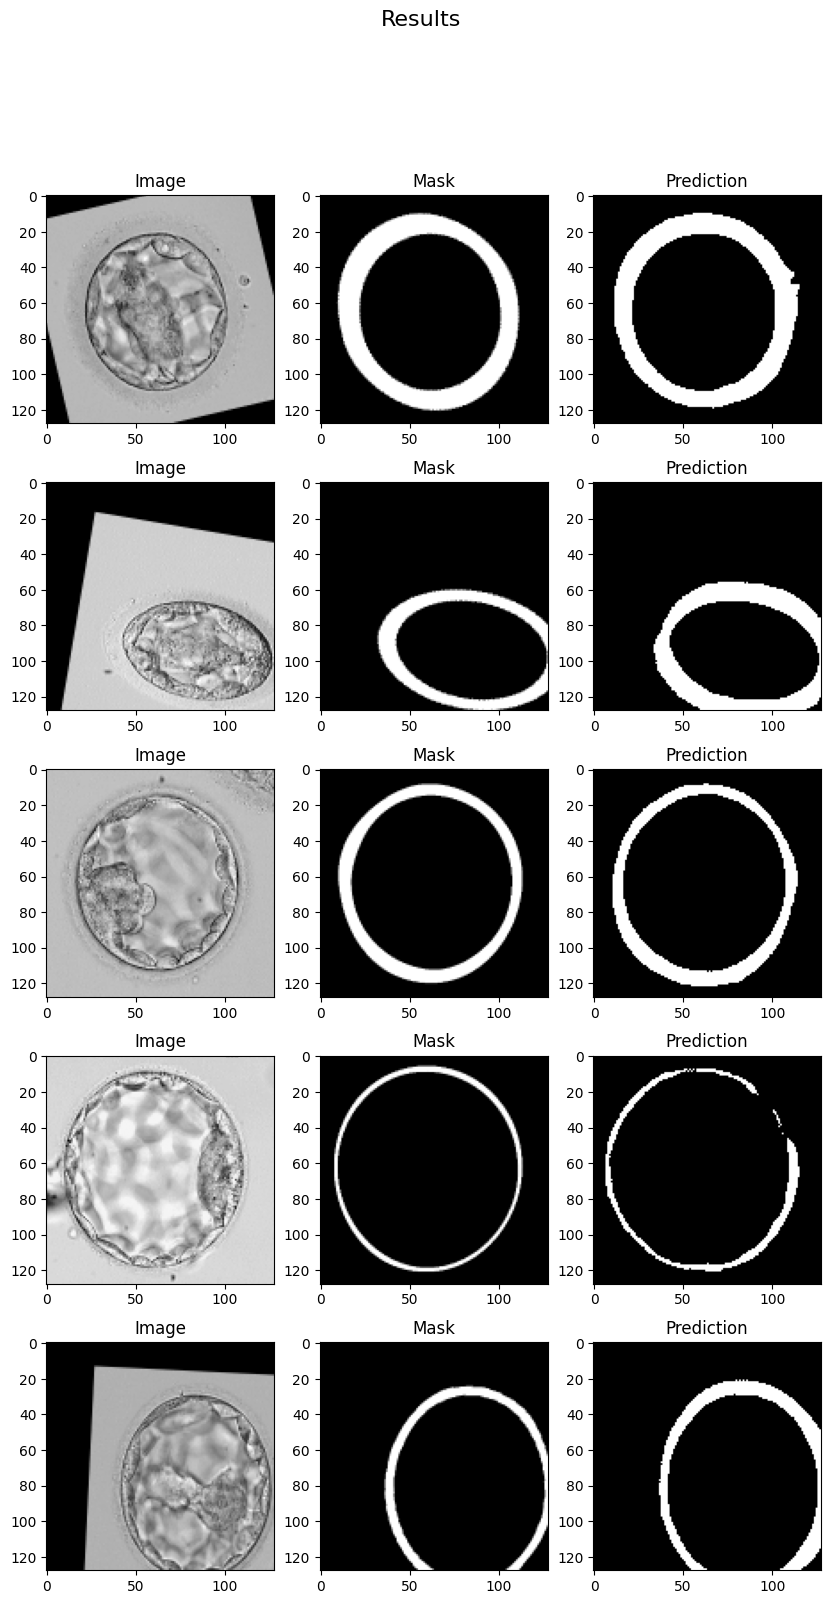

In [11]:
fig, ax = plt.subplots(5, 3, figsize=(10, 18))

j = np.random.randint(0, X_val.shape[0], 5)
for i in range(5):
    ax[i, 0].imshow(X_val[j[i]], cmap='gray')
    ax[i, 0].set_title('Image')

    ax[i, 1].imshow(y_val[j[i]], cmap='gray')
    ax[i, 1].set_title('Mask')

    # Get prediction, apply threshold
    pred = model.predict(np.expand_dims(X_val[j[i]], 0), verbose=0)[0]
    pred = (pred > 0.5).astype(np.uint8)  # Apply threshold

    ax[i, 2].imshow(pred, cmap='gray')
    ax[i, 2].set_title('Prediction')

fig.suptitle('Results', fontsize=16)
plt.show()

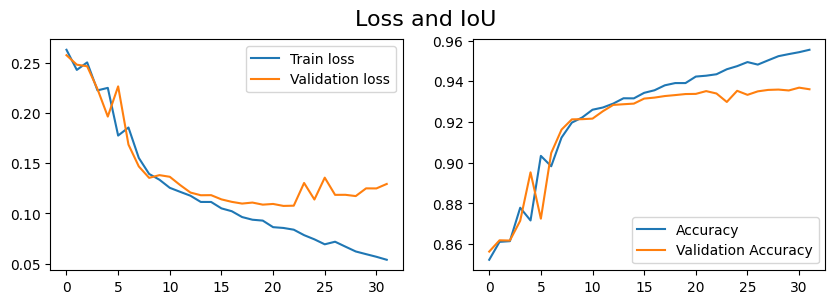

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
ax[1].legend()
fig.suptitle('Loss and IoU', fontsize=16)
plt.show()